## 1. 데이터 수집하기

In [10]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
path = os.getenv('HOME') + '/aiffel/transformer_chatbot/data/ChatbotData .csv'
data = pd.read_csv(path)

In [13]:
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


우리가 사용할 데이터는 질문과 대답으로 이루어진 데이터셋이다.

## 2. 데이터 전처리하기

데이터 전처리하는 단계는 다음과 같다.
* 1. TensorFlow Datasets SubwordTextEncoder를 토크나이저로 사용한다.  단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고,  각 토큰을 고유한 정수로 인코딩한다.
* 2. 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 START_TOKEN 및 END_TOKEN을 추가한다.
* 3. 최대 길이 MAX_LENGTH인 40을 넘는 문장들은 필터링한다.
* 4. MAX_LENGTH보다 길이가 짧은 문장들은 40에 맞도록 패딩 한다

**먼저 토큰화를 진행하기전에,단어와 구두점 사이의 거리를 만들고, 가-힣, 구두점을 제외한 모든 문자를 ' '로 대체하고, questions과 answers list에 담아주자**

In [16]:
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (가-힣, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^가-힣?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence


In [20]:
def preprocess(data):
    questions = []
    for sentence in data['Q']:
        sentence = sentence.strip()
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)
        sentence = re.sub(r"[^가-힣?.!,]+", " ", sentence)
        sentence = sentence.strip()
        questions.append(sentence)
        
    answers = []
    for sentence in data['A']:
        sentence = sentence.strip()
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)
        sentence = re.sub(r"[^가-힣?.!,]+", " ", sentence)
        sentence = sentence.strip()
        answers.append(sentence)
    
    
    return questions,answers

In [21]:
questions, answers = preprocess(data)

In [23]:
print('전체 질문 수 :', len(questions))
print('전체 답변 수 :', len(answers))

전체 질문 수 : 11823
전체 답변 수 : 11823


**전처리가 잘 되었는지 확인해보자.**

In [27]:
print(f"질문:{questions[5]}, 대답:{answers[5]}")

질문:카드 망가졌어, 대답:다시 새로 사는 게 마음 편해요 .


### 토큰화
**질문과 답변 데이터셋을 모두 사용하여 단어장을 만들어보자. 이때 TensorFlow Datasets SubwordTextEncoder을 사용한다.**

In [29]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. 
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)


**단어 집합이 생성되었다. 트랜스포머의 디코더에는 시작토큰과 종료토큰이 필요한데, 이 토큰들은 아직 정수화 되지 않았기 때문에 정수화를 진행해보자.**


In [30]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [32]:
VOCAB_SIZE = tokenizer.vocab_size + 2

In [33]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [8127]
종료 토큰 번호 : [8128]
단어 집합의 크기 : 8129


### 정수 인코딩 

우리는 위에서 토큰화를 진행하고, 단어장을 만들었기 때문에 tokenizer.encode()로 각 단어를 정수로 변환할 수 있고 또는 tokenizer.decode()를 통해 정수 시퀀스를 단어 시퀀스로 변환할 수 있다. 


In [41]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.

print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5742, 612, 2481, 4148]
정수 인코딩 후의 21번째 답변 샘플: [2352, 7481, 7, 6245, 97, 1]


### 패딩
토큰 수의 분포를 확인해보고, 알맞은 길이의 문장 최대길이를 정해보자. 그 후 부족한 문장은 패딩처리를 수행해보자.

토큰 수 평균 :  14.596422227860948
토큰 수 최대 :  78
토큰 수 표준편차:  6.745239180299319


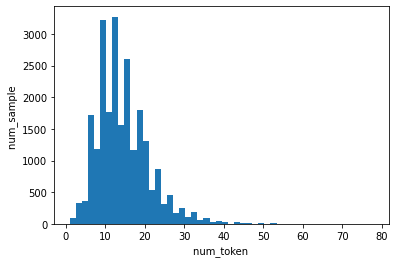

In [51]:
import matplotlib.pyplot as plt

num_token= [len(tokens) for tokens in questions+answers]
num_token = np.array(num_token)

print('토큰 수 평균 : ', np.mean(num_token))
print('토큰 수 최대 : ', np.max(num_token))
print('토큰 수 표준편차: ',np.std(num_token))
plt.hist([len(token) for token in questions+answers], bins=50)
plt.xlabel('num_token ')
plt.ylabel('num_sample ')
plt.show()

In [58]:
#임의로 30으로 지정
max_token = 30
MAX_LENGTH = int(max_token)
print('pad_sequences maxlen : ', MAX_LENGTH)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_token < max_token) / len(num_token)))

pad_sequences maxlen :  30
전체 문장의 0.9683244523386619%가 maxlen 설정값 이내에 포함됩니다. 


**maxlen을 30으로 지정했을때, 전체 문장의 약 97%가 이 길이 내에 포함되므로 maxlen=30이 적절한 수치인것 같다.**

**그렇다면, 정수 인코딩, 문장 길이 조절, 패딩, 시작토큰 종료토큰 추가하는 함수를 생성해보자.**

In [61]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 30 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 30으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs


In [62]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8129
필터링 후의 질문 샘플 개수: 11822
필터링 후의 답변 샘플 개수: 11822


### 인코더와 디코더의 입력 만들기 + 교사강요

질문과 답변의 쌍을 tf.data.Dataset API의 입력으로 사용하여 파이프라인을 구성한다. 이때, 교사 강요를 위해서 answers[:, :-1]를 디코더의 입력값, answers[:, 1:]를 디코더의 레이블로 사용한다.

In [64]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용하기 때문에 outputs에서는 START_TOKEN을 제거.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)


## 3. 트랜스포머 정의

In [68]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


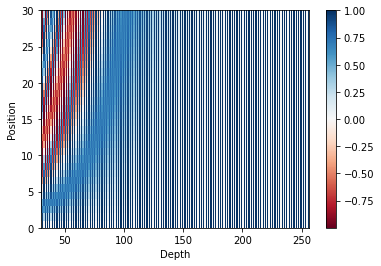

In [69]:
sample_pos_encoding = PositionalEncoding(30, 256)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((30, 256))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [71]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [72]:
#멀티 헤드 어텐션
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs


In [73]:
#패딩마 스크
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [74]:
#룩어헤드 마스크
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [76]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [77]:
#인코더 층 쌓기
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [78]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


In [79]:
#디코더 층 쌓기
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


In [80]:
#트랜스포머 구현
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


## 4. 모델 학습

### 모델 생성

In [81]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3135232     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 손실 함수
레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 한다.

In [83]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)


### 커스텀 된 학습률

In [84]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


Text(0.5, 0, 'Train Step')

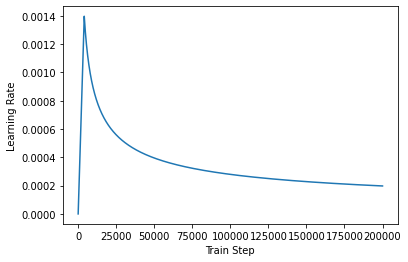

In [85]:
# 시각화
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### 모델 컴파일

In [86]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])


### 모델 훈련


In [93]:
EPOCHS = 100
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/100
185/185 [==============================] - 8s 45ms/step - loss: 0.2067 - accuracy: 0.1948
Epoch 2/100
185/185 [==============================] - 8s 45ms/step - loss: 0.1497 - accuracy: 0.2052
Epoch 3/100
185/185 [==============================] - 8s 45ms/step - loss: 0.1095 - accuracy: 0.2126
Epoch 4/100
185/185 [==============================] - 8s 45ms/step - loss: 0.0842 - accuracy: 0.2169
Epoch 5/100
185/185 [==============================] - 8s 45ms/step - loss: 0.0705 - accuracy: 0.2194
Epoch 6/100
185/185 [==============================] - 8s 45ms/step - loss: 0.0629 - accuracy: 0.2204
Epoch 7/100
185/185 [==============================] - 8s 44ms/step - loss: 0.0583 - accuracy: 0.2209
Epoch 8/100
185/185 [==============================] - 8s 44ms/step - loss: 0.0546 - accuracy: 0.2219
Epoch 9/100
185/185 [==============================] - 8s 45ms/step - loss: 0.0502 - accuracy: 0.2228
Epoch 10/100
185/185 [==============================] - 8s 44ms/step - loss: 0.042

185/185 [==============================] - 8s 44ms/step - loss: 0.0032 - accuracy: 0.2342
Epoch 81/100
185/185 [==============================] - 8s 44ms/step - loss: 0.0030 - accuracy: 0.2342
Epoch 82/100
185/185 [==============================] - 8s 44ms/step - loss: 0.0028 - accuracy: 0.2342
Epoch 83/100
185/185 [==============================] - 8s 44ms/step - loss: 0.0028 - accuracy: 0.2342
Epoch 84/100
185/185 [==============================] - 8s 44ms/step - loss: 0.0025 - accuracy: 0.2343
Epoch 85/100
185/185 [==============================] - 8s 44ms/step - loss: 0.0027 - accuracy: 0.2342
Epoch 86/100
185/185 [==============================] - 8s 45ms/step - loss: 0.0026 - accuracy: 0.2342
Epoch 87/100
185/185 [==============================] - 8s 44ms/step - loss: 0.0027 - accuracy: 0.2342
Epoch 88/100
185/185 [==============================] - 8s 45ms/step - loss: 0.0028 - accuracy: 0.2342
Epoch 89/100
185/185 [==============================] - 8s 44ms/step - loss: 0.0026 - 

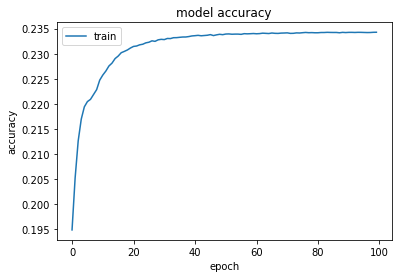

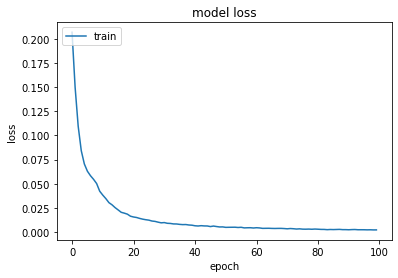

In [94]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

## 5. 모델 테스트


**예측은 다음과 같이 6단계를 따른다. 6단계를 모두 포함하는 함수를 만들어보자.**
* 1.새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
* 2.입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
* 3.패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
* 4.디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
* 5.디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
* 6.END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

In [95]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)


어떤 문장에 대해 decoder_inference 호출하여 챗봇의 대답을 출력하는 함수를 만들어보자.

In [96]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence


In [98]:
sentence_generation('안녕하세요')

입력 : 안녕하세요
출력 : 안녕하세요 .


'안녕하세요 .'

In [100]:
sentence_generation('오늘 날씨는?')

입력 : 오늘 날씨는?
출력 : 마음 가는 대로 해보세요 .


'마음 가는 대로 해보세요 .'

In [104]:
sentence_generation('오늘 날씨를 알려줘')

입력 : 오늘 날씨를 알려줘
출력 : 하늘 보고 한 번 웃어봐요 . 기분이 바뀔 거예요 .


'하늘 보고 한 번 웃어봐요 . 기분이 바뀔 거예요 .'

In [105]:
sentence_generation('커피 마시고 싶다.')

입력 : 커피 마시고 싶다.
출력 : 카페인이 필요한 시간인가 봐요 .


'카페인이 필요한 시간인가 봐요 .'

In [111]:
sentence_generation('밥 먹고싶다.')

입력 : 밥 먹고싶다.
출력 : 엄청난 용기가 필요하겠네요 .


'엄청난 용기가 필요하겠네요 .'

In [112]:
sentence_generation('배고프다')

입력 : 배고프다
출력 : 저도 밥 먹고 싶어요


'저도 밥 먹고 싶어요'

In [113]:
sentence_generation('공부는 힘들어')

입력 : 공부는 힘들어
출력 : 확신이 없나봐요 .


'확신이 없나봐요 .'

In [115]:
sentence_generation('게임')

입력 : 게임
출력 : 저도 좀 알려주세요 .


'저도 좀 알려주세요 .'

In [116]:
sentence_generation('인공지능은 어려워')

입력 : 인공지능은 어려워
출력 : 잠시 거리를 두고 생각해보세요 .


'잠시 거리를 두고 생각해보세요 .'

In [117]:
sentence_generation('게임은 어려워')

입력 : 게임은 어려워
출력 : 먼저 게임할때는 시간이 더 빨리 가요 .


'먼저 게임할때는 시간이 더 빨리 가요 .'

In [118]:
sentence_generation('공부는 어려워')

입력 : 공부는 어려워
출력 : 확신이 없나봐요 .


'확신이 없나봐요 .'

## 회고

* 이번 노드는 대표적인 기계번역 모델인 트랜스포머와 이를 이용해 챗봇을 만들어보는 노드였다.
* 다행히 이번 풀잎스쿨 시간에 트랜스포머에 대한 발표를 하게 돼서 트랜스포머의 구조나 코드 구현 등에 대해 개략적은 알고 있어서,모델을 이론적으로 이해할때 크게 어려운 과정은 없었던것 같다.
* 이번 노드를 진행할때 어려웠던점은 트랜스포머를 구현할때, 텐서플로우 라이브러리를 이용한 수식이나 문법이 많아서 그 부분을 이해하기가 굉장히 어려웠다. 텐서플로우 문법도 모델을 깊이 이해하기 위해서는 꼭 필요한 것 같다.
* 매번 NLP노드를 진행하면서 드는 생각이지만 이게 어떻게 학습이 되지? 라는 생각이 든다. 또한 이번에는 validation set을 안썼는데 원래 NLP에서는 안쓰는지 의문이다.
* NLP를 좀 더 체계화 시켜서 공부해야겠다는 생각이 있다. 토큰화, 임베딩, 모델 구현 등 NLP에 어떤 내용이 있고 따로따로는 조금이나마 알겠는데 순서와 과정이 조금 헷갈려서 처음부터 다시 공부해보고 싶다.